In [348]:
# NN libraries
import torch
import torch.nn as nn

# Libraries for solving PDE numerically and plotting
import numpy as np
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse import diags
from scipy.sparse.linalg import factorized

In [349]:
seed = 123
torch.manual_seed(seed)
np.random.seed(seed)

def sin(x):
    if isinstance(x, torch.Tensor): 
        return torch.sin(x)
    else:
        return np.sin(x)

def exp(x):
    if isinstance(x, torch.Tensor): 
        return torch.exp(x)
    else:
        return np.exp(x)

from pathlib import Path
# Create used directories
directories = ["gifs", "PINN_Plots"]
for d in directories:
    plots_dir = Path(d)
    plots_dir.mkdir(exist_ok=True)
    print(f"Directory '{plots_dir}' is present. ✅")


Directory 'gifs' is present. ✅
Directory 'PINN_Plots' is present. ✅


In [350]:
# Define PDE Parameters
xi, xf, dx = 0, 1, 1e-2
ti, tf, dt = 0, 1, 1e-2

a = 1e-2

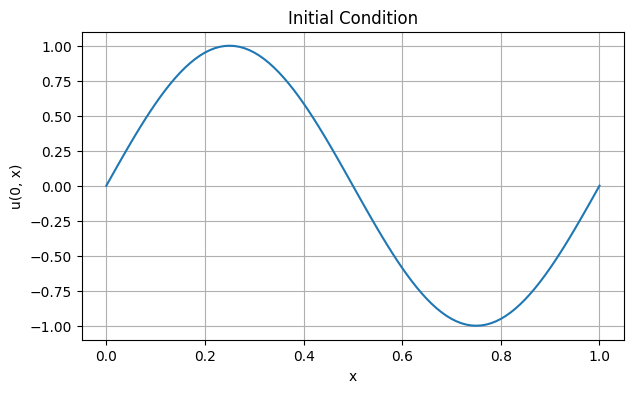

In [351]:
# Initial conditions

x = np.arange(xi, xf + dx, dx, dtype=np.float32)
t = np.arange(ti, tf + dt, dt, dtype=np.float32)
Nx, Nt = len(x), len(t)

def u0(x):
    return sin(2*np.pi*x)

fig, ax = plt.subplots(figsize=(7, 4))
ax.plot(x, u0(x))
ax.set_xlabel('x')
ax.set_ylabel('u(0, x)')
ax.set_title('Initial Condition')
ax.grid()
plt.show()

In [352]:
# Create matricies for solving PDE
u = np.zeros((Nt, Nx))

def D2_t():
    "4th order second derivative centred finite difference matrix with periodic boundary conditions"
    D = 1/(dx**2) * diags([-1, 16, -30, 16, -1], [-2, -1, 0, 1, 2], shape=(Nx, Nx)).toarray()
    D[0, [-2, -1]] = [-1/(dx**2), 16/(dx**2)]
    D[1, [-1]] = [-1/(dx**2)]
    D[-1, [0, 1]] = [16/(dx**2), -1/(dx**2)]
    D[-2, [0, 1]] = [-1/(dx**2)]
    return sparse.csr_matrix(D)

u = np.zeros((Nt, Nx))
I = diags([1], [0], shape=(Nx, Nx))
A = (I - dt/2 * a*D2_t())
B = (I + dt/2 * a*D2_t())
solve_A = factorized(A.tocsc())

t = 0.000s, u_max = 1.000
t = 0.100s, u_max = 0.628
t = 0.200s, u_max = 0.399
t = 0.300s, u_max = 0.256
t = 0.400s, u_max = 0.165
t = 0.500s, u_max = 0.107
t = 0.600s, u_max = 0.071
t = 0.700s, u_max = 0.047
t = 0.800s, u_max = 0.033
t = 0.900s, u_max = 0.023
t = 1.000s, u_max = 0.017


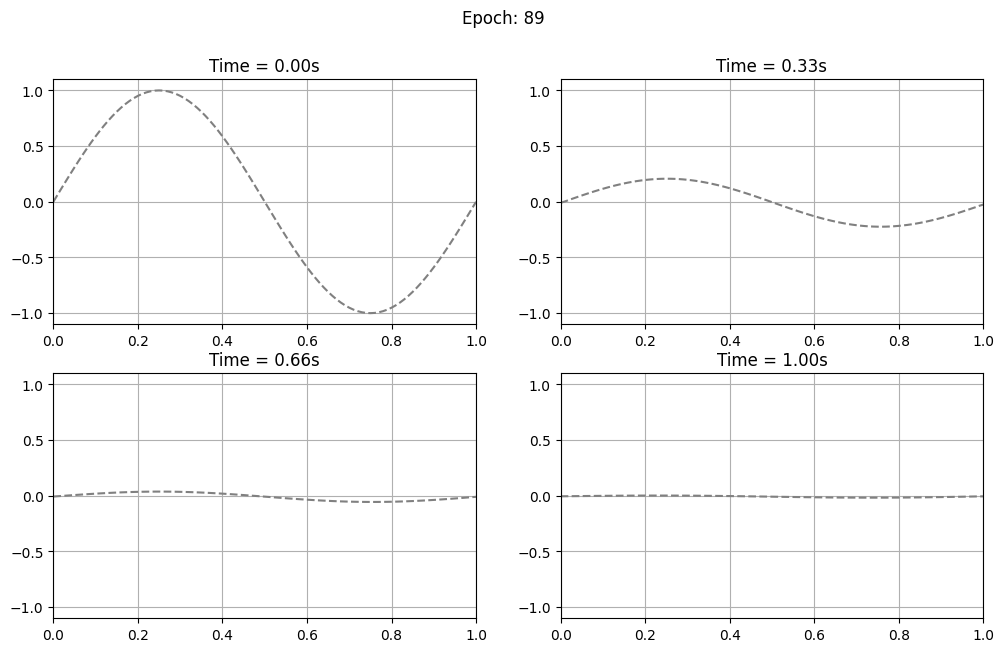

In [353]:
# Numerically Solve PDE wth Crank-Nicolson method

for j, tj in enumerate(t):
    if j == 0:
        u[0, :] = u0(x)
    else:
        uj = u[j-1, :]
        u[j, :] = solve_A(B @ uj)
    if j % int(1/dt * 1e-1) == 0: # Every once in a while print some info on solving
        print(f"t = {tj:.3f}s, u_max = {np.max(np.abs(u[j, :])):.3f}")


fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
for j, ax in enumerate(axs.flat):
    tj = time_indecies[j]
    ax.plot(x, u[tj, :], c="gray", linestyle='--')
    ax.set_title(f"Time = {t[tj]:.2f}s")
    ax.grid()
    ax.set_ylim(-1.1, 1.1)
    ax.set_xlim(xi, xf)

fig.suptitle(f"Epoch: {i}")
plt.show()

In [354]:
def training_plot(save=False, file_name=""):
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(12, 7))
    titles = ['t = 0', 't=0.25', 't = 0.5', 't = 1']
    time_indecies = torch.linspace(0, Nt-1, 4, dtype=int)
    for j, ax in enumerate(axs.flat):
        tj = time_indecies[j]
        ax.plot(x, p[tj, :], c='blue')
        ax.plot(x, u[tj, :], c="gray", linestyle='--')
        ax.set_title(f"Time = {t[tj]:.2f}s")
        ax.grid()
        ax.set_ylim(-1.1, 1.1)
        ax.set_xlim(xi, xf)
        ax.scatter(boundary1_domain[0, 1], u[tj, 0], s=20, color="purple")
        ax.scatter(boundary2_domain[0, 1], u[tj, -1], s=20, color="purple", label="Boundary Condition")
        ax.scatter(x_col, torch.zeros_like(x_col), color="green", label="Colocation Points", s=5)
    
    axs[0, 0].scatter(initial_x, u0(initial_x), color="red", s=10, label="Initial Condition")
    axs[0, 1].scatter(x_data, u[time_indecies[1], x_indecies], color="black", s=10, label="Training Data")
    fig.suptitle(f"Epoch: {i}")
    axs[0,0].legend()
    axs[0,1].legend()
    
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [355]:
# Define PINN architecture

class FCN(nn.Module):
    def __init__(self, N_INPUT, N_OUTPUT, N_HIDDEN, N_LAYERS):
        super().__init__()
        activation = nn.Tanh
        
        self.fcs   = nn.Sequential(*[nn.Linear(N_INPUT, N_HIDDEN),activation()])
        self.fch   = nn.Sequential(*[nn.Sequential(*[nn.Linear(N_HIDDEN, N_HIDDEN), activation()]) for _ in range(N_LAYERS-1)])
        self.fce   = nn.Linear(N_HIDDEN, N_OUTPUT)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight) 
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
        
    def forward(self, x):
        x = self.fcs(x)
        x = self.fch(x)
        x = self.fce(x)
        return x

In [356]:
# Define PINN Hyperparameters

learning_rate = 1e-2
epochs        = 10_000 + 1
w_initial     = 1e0
w_boundary    = 1e-1
w_data        = 1e1
w_PDE         = 1e2

N_initial  = 50
N_boundary = 50
N_training_t = 50
N_training_x = 50
N_col      = 100

N_layers = 8
N_nodes  = 60

In [357]:
# Domain for initial condition
initial_x = torch.linspace(xi, xf, N_initial)
initial_t = torch.zeros(N_initial)
initial_domain = torch.stack((initial_t, initial_x), dim=1)
initial_u = u0(initial_x).view(-1,1)

# Domain for boundary condition
boundary1_domain = torch.stack((torch.linspace(ti, tf, N_boundary),  x[0]*torch.ones(N_boundary)), dim=1)
boundary2_domain = torch.stack((torch.linspace(ti, tf, N_boundary), x[-1]*torch.ones(N_boundary)), dim=1)

# Domain for training data
t_indecies = torch.linspace(1, 2*(Nt-1)//5, N_training_t, dtype=int) # Defined in terms of indecies to make getting u and corresponding (t,x) values easier
x_indecies = torch.linspace(1, Nx-1, N_training_x, dtype=int)
Ti_mat, Xi_mat = torch.meshgrid(t_indecies, x_indecies, indexing='ij')

t_data = (torch.from_numpy(t))[t_indecies]
x_data = (torch.from_numpy(x))[x_indecies]
Td, Xd = torch.meshgrid(t_data, x_data, indexing='ij')
training_domain = torch.stack((Td.flatten(), Xd.flatten()), dim=1) # (t, x) values that correspond to the u values used for training
training_u      = torch.from_numpy(u)[Ti_mat, Xi_mat].view(-1,1)   # Values of u used in training

# Domain for collocation points
t_col  = torch.linspace(ti, tf, N_col)
x_col  = torch.linspace(xi, xf, N_col)
Tc, Xc = torch.meshgrid(t_col, x_col, indexing='ij')
colocation_domain = torch.stack((Tc.flatten(), Xc.flatten()), dim=1).requires_grad_(True)

# Domain for Error calculation
T, X = torch.meshgrid(torch.from_numpy(t), torch.from_numpy(x), indexing='ij')
input_Domain = torch.stack((T.flatten(), X.flatten()), dim=1)

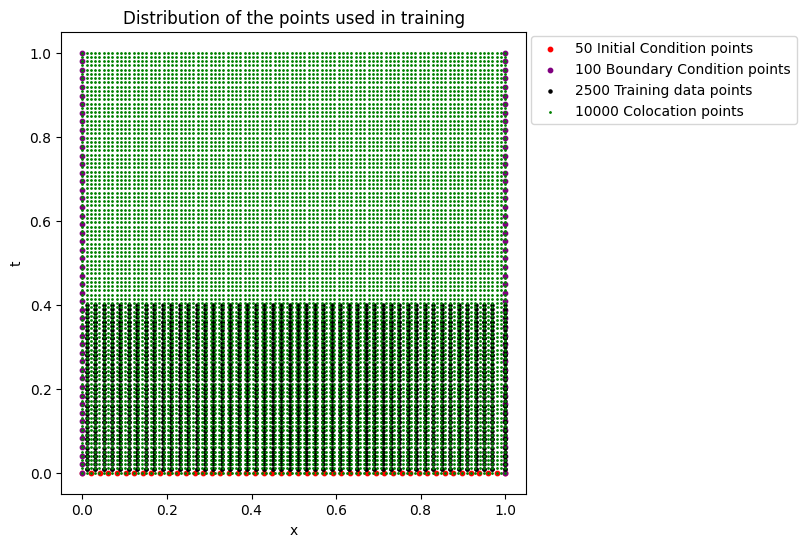

In [358]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.scatter(initial_x, initial_t, s=10, color="Red", label=f"{N_initial} Initial Condition points")
ax.scatter(boundary1_domain[:,1], boundary1_domain[:,0], s=10, color="purple")
ax.scatter(boundary2_domain[:,1], boundary2_domain[:,0], s=10, color="purple", label=f"{2*N_boundary} Boundary Condition points")
ax.scatter(training_domain[:,1], training_domain[:,0], s= 5, color="black", label=f"{len(training_domain)} Training data points")
ax.scatter(colocation_domain.detach()[:,1], colocation_domain.detach()[:,0], s=1, color="green", label=f"{N_col**2} Colocation points", zorder=1)
ax.legend(loc=(1.01, 0.8))
ax.set_ylabel("t")
ax.set_xlabel("x")
ax.set_title("Distribution of the points used in training")
plt.show()

Epoch: 0, Loss: 1.5843e+01, MSE = 1.1896e+00


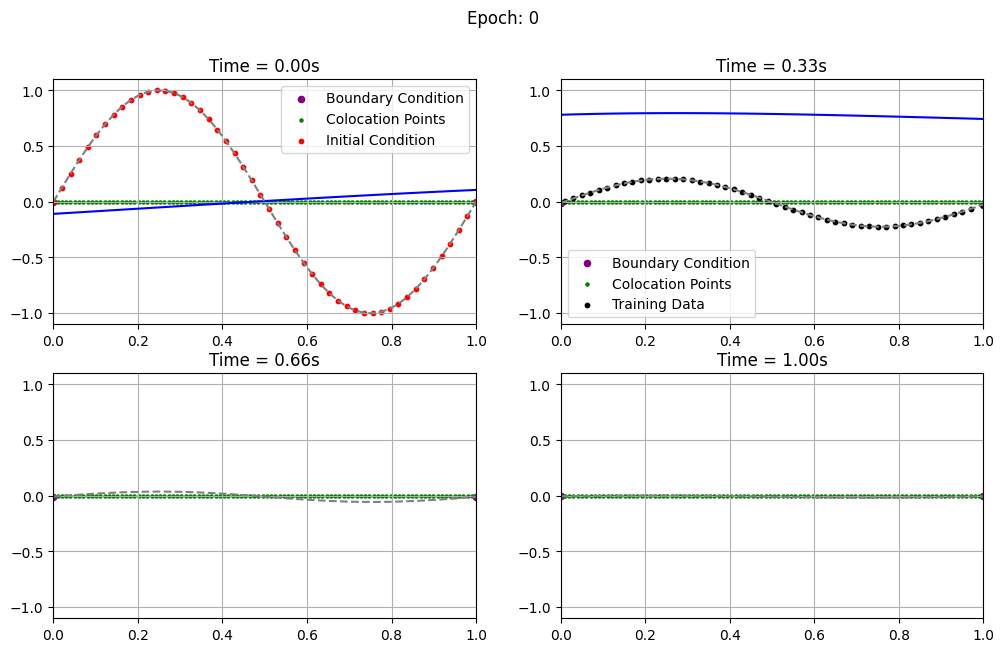

Epoch: 1000, Loss: 3.5201e-01, MSE = 4.7408e-02
Epoch: 2000, Loss: 3.3995e-01, MSE = 4.9217e-02
Epoch: 3000, Loss: 3.3995e-01, MSE = 4.9217e-02
Epoch: 4000, Loss: 3.3995e-01, MSE = 4.9217e-02
Epoch: 5000, Loss: 3.3995e-01, MSE = 4.9217e-02


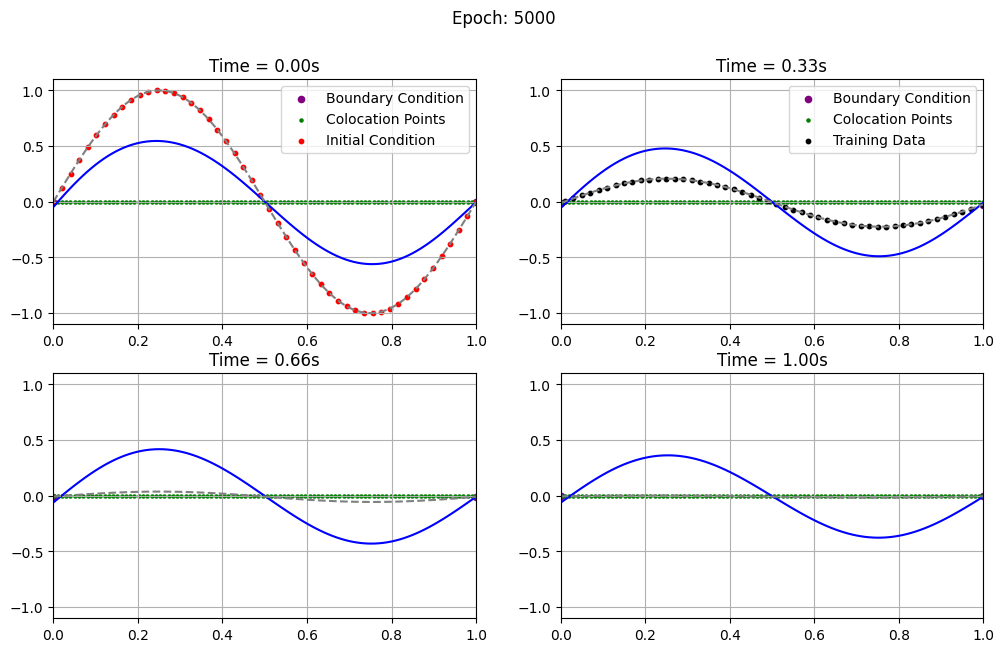

Epoch: 6000, Loss: 3.3995e-01, MSE = 4.9217e-02
Epoch: 7000, Loss: 3.3995e-01, MSE = 4.9217e-02
Epoch: 8000, Loss: 3.3995e-01, MSE = 4.9216e-02
Epoch: 9000, Loss: 3.3995e-01, MSE = 4.9217e-02
Epoch: 10000, Loss: 3.3994e-01, MSE = 4.9216e-02


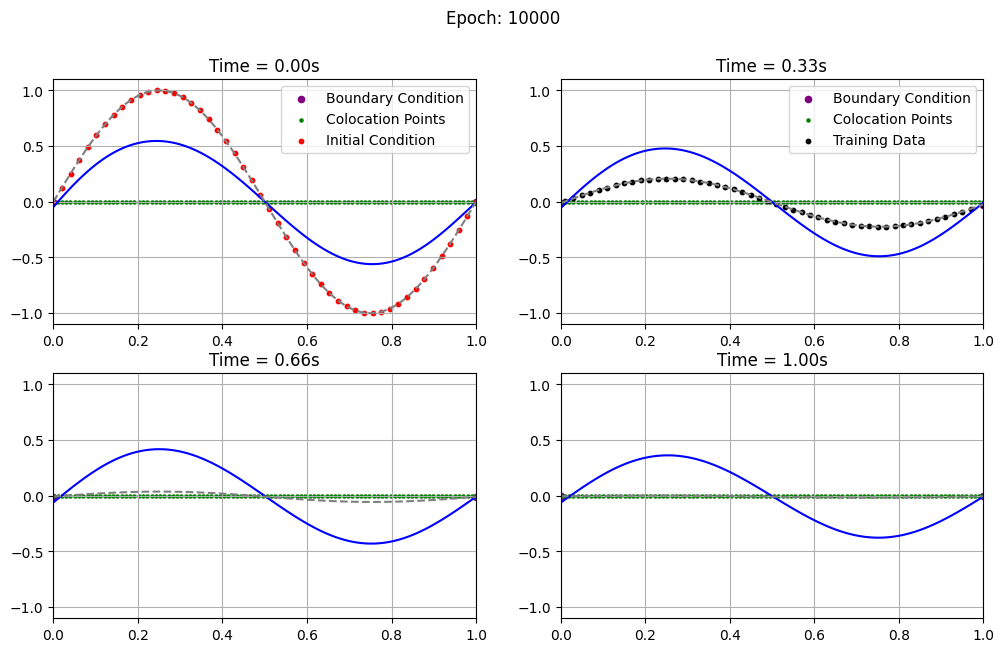

In [359]:
# Neural Network without physics

Diffusion_PINN = FCN(2, 1, N_nodes, N_layers) # 2 inputs and 1 output since u: RxR -> R, u: (t,x)|->u(t,x)
optimizer      = torch.optim.Adam(Diffusion_PINN.parameters(), lr=learning_rate) # Using the Adam optimizer
scheduler      = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=50, min_lr=1e-6) 

mse_history  = []
loss_history = []
pde_loss_history  = []
data_loss_history = []
initial_loss_history = []
boundary_loss_history = []

for i in range(epochs):
    Diffusion_PINN.train()
    optimizer.zero_grad()
    
    # Initial Loss
    initial_p    = Diffusion_PINN(initial_domain)
    loss_initial = torch.mean((initial_p - initial_u)**2)
    
    # Boundary Loss
    boundary1_p = Diffusion_PINN(boundary1_domain)
    boundary2_p = Diffusion_PINN(boundary2_domain)
    loss_boundary = torch.mean((boundary1_p - boundary2_p)**2)
    
    # Data Loss
    s = Diffusion_PINN(training_domain)
    loss_data = torch.mean((s - training_u)**2)
    
    # Physics Loss
    v  = Diffusion_PINN(colocation_domain)
    Dv = torch.autograd.grad(v, colocation_domain, torch.ones_like(v), create_graph=True)[0]
    
    v_t  = Dv[:, 0:1]
    v_x  = Dv[:, 1:2]
    
    Dv_x = torch.autograd.grad(v_x, colocation_domain, torch.ones_like(v_x), create_graph=True)[0]
    v_xx = Dv_x[:, 1:2]
    
    loss_PDE = torch.mean((v_t - a*v_xx)**2)

    # Total Loss
    loss = w_initial*loss_initial + w_boundary*loss_boundary + w_data*loss_data + w_PDE*loss_PDE
    
    loss.backward()
    optimizer.step()
    scheduler.step(loss)
    
    Diffusion_PINN.eval()
    
    # Finds the Mean Squared Error with the real solution
    P = Diffusion_PINN(input_Domain).detach()
    p = P.numpy().reshape(Nt, Nx)
    MSE = np.mean((u - p)**2)
    
    loss_history.append(loss.item())
    pde_loss_history.append(loss_PDE.item())
    data_loss_history.append(loss_data.item())
    boundary_loss_history.append(loss_boundary.item())
    initial_loss_history.append(loss_initial.item())
    
    if i % 1000 == 0:
        print(f"Epoch: {i}, Loss: {loss.item():.4e}, MSE = {MSE:.4e}")
        if i % 5000 == 0:
            training_plot()
            plt.show()

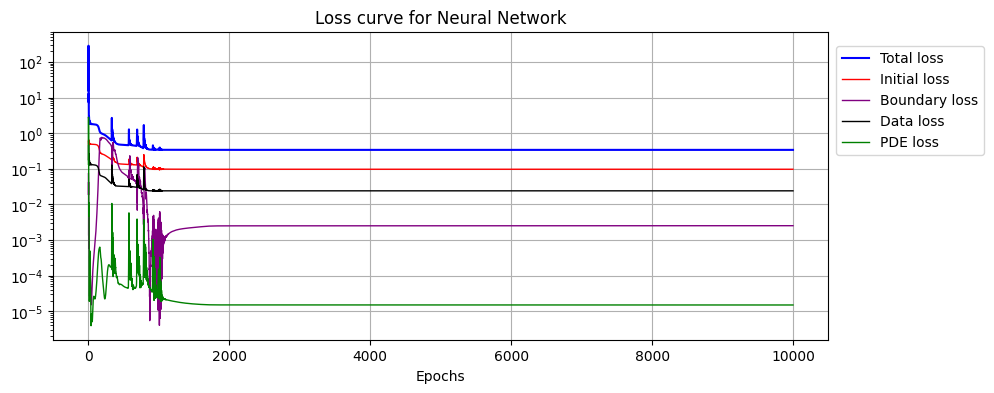

In [360]:
lw = 1
fig, ax = plt.subplots(figsize=(10, 4))
ax.set_title("Loss curve for Neural Network")
ax.plot(loss_history, label="Total loss", c="blue")
ax.plot(initial_loss_history, label="Initial loss", c="red", lw=lw)
ax.plot(boundary_loss_history, label="Boundary loss", c="purple", lw=lw)
ax.plot(data_loss_history, label="Data loss", c="black", lw=lw)
ax.plot(pde_loss_history, label="PDE loss", c="green", lw=lw)
ax.set_xlabel("Epochs")
ax.set_yscale("log")
ax.legend(loc=(1.01, 0.6))
ax.grid()
plt.show()

In [361]:
from PIL import Image

def save_gif_PIL(outfile, files, fps=5, loop=0):
    imgs = [Image.open(file) for file in files]
    imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=round(1000/fps), loop=loop)

def make_plot(save=False, file_name=f"PDE_solution.png", ti=0):
    fig, ax = plt.subplots()
    ax.plot(x, u[i, :], label='Numerical Solution Solution', linestyle='--', c="black")
    ax.plot(x, p[i, :], label='PINN Solution', c="blue")
    ax.set_xlim(xi, xf)
    ax.set_ylim(-1.05, 1.05)
    ax.grid()
    ax.set_title(f"Time = {ti:.3f}s")
    ax.legend()
    if save:
        fig.savefig(file_name, bbox_inches="tight", pad_inches=0.1, dpi=100, facecolor="white")

In [362]:
import os
import shutil

folder_path="PINN_plots"
for item in os.listdir(folder_path):
    item_path = os.path.join(folder_path, item)
    try:
        if os.path.isfile(item_path) or os.path.islink(item_path):
            os.unlink(item_path)  # Remove file or symbolic link
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)  # Remove subdirectory and its contents
    except Exception as e:
        print(f"Failed to delete {item_path}. Reason: {e}")

In [363]:
files = []
fps   = 20
frame_indicies = np.linspace(0, Nt-1, 3*int(fps*t[-1]), dtype=int)
N_frames = len(frame_indicies)
for i, index in enumerate(frame_indicies):
    tj = t[index]
    file = f"PINN_plots/PDE_sol_{tj:.5f}.png"
    make_plot(save=True, file_name=file, ti=tj)
    files.append(file)
    plt.close("all")
    print(f"{i}/{N_frames}")
    
save_gif_PIL("gifs/Diffusion_PINN_Comparison.gif", files, fps=fps, loop=0)

0/60
1/60
2/60
3/60
4/60
5/60
6/60
7/60
8/60
9/60
10/60
11/60
12/60
13/60
14/60
15/60
16/60
17/60
18/60
19/60
20/60
21/60
22/60
23/60
24/60
25/60
26/60
27/60
28/60
29/60
30/60
31/60
32/60
33/60
34/60
35/60
36/60
37/60
38/60
39/60
40/60
41/60
42/60
43/60
44/60
45/60
46/60
47/60
48/60
49/60
50/60
51/60
52/60
53/60
54/60
55/60
56/60
57/60
58/60
59/60
